In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import seaborn as sns

#these are user defined modules
import plot
import calculate


# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 15
END_YEAR = 2015

### Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

In [2]:
start_time = timeit.default_timer()
print(start_time)

1812040.387970225


### Read Gender details

In [3]:
# read gender details - the column names are name, gender - change it to author, gender
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone.txt')
print(gender.shape)
gender = gender.drop_duplicates()
print(gender.shape)
# Gender file is full of duplicates. As we use the author's name as ID, duplicate entries provide no extra info
gender.rename(columns={'name':'author'}, inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender.groupby('gender').size())

(9471728, 2)
(1704919, 2)
          author gender
0   gareth beale      m
1    graeme earl      m
2  altaf hossain      m
3   faisal zaman      m
4      m. nasser   none
['m' 'none' 'f']
gender
f       255413
m       792817
none    656689
dtype: int64
1704919


### Read authors with start and end year details

In [21]:
# Different files exists depending upon their career length

#authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')


print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

print("author unique names  - ", authorStartEndCareerData['author'].nunique())
authorStartEndCareerData.head()

authorStartEndCareerData before filtering -  112791
authorStartEndCareerData after filtering -  112791
author unique names  -  112791


,author,start_year,end_year,total_num_pub,career_length
0,a min tjoa,1979,2017,191,38
1,a-xing zhu,1998,2017,22,19
2,a. a. (louis) beex,1980,2016,31,36
3,a. a. abouelsoud,1996,2016,10,20
4,a. a. ball,1988,2006,5,18


### Merge credible authors and their gender information

In [22]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')

# print("authorStartEndCareerData with duplicates: ", authorStartEndCareerData.shape[0])
# authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: ", authorStartEndCareerData.shape[0])

authorStartEndCareerData.head()

authorStartEndCareerData no duplicates:  112791


,author,start_year,end_year,total_num_pub,career_length,gender
0,a min tjoa,1979,2017,191,38,none
1,a-xing zhu,1998,2017,22,19,none
2,a. a. (louis) beex,1980,2016,31,36,m
3,a. a. abouelsoud,1996,2016,10,20,m
4,a. a. ball,1988,2006,5,18,m


### Read Citation data

In [16]:
authorCitationsData = pd.read_csv('./data/authors_cite_2017_asiansAsNone_by_daniel.txt')
# Using file made by daniel

#id1 represents the author who cited
#id2 is the author who has been cited by id1 in year Y
authorCitationsData.rename(columns={'author_cited':'author', 'year_cit':'year'}, inplace=True)

print('authorCitationsData before filtering - ',authorCitationsData.shape[0])
authorCitationsData = authorCitationsData[authorCitationsData["year"] >= 1970]
print('authorCitationsData after filtering - ',authorCitationsData.shape[0])

#Group by both year and author - multi index and hierarchial indexing
authorCitationsData = authorCitationsData.groupby(['year','author']).count().reset_index()
authorCitationsData.rename(columns={'author_citing':'num_cit'}, inplace=True)
print(authorCitationsData.head())

print('authorCitationsData after grouping - ',authorCitationsData.shape)

authorCitationsData[authorCitationsData.author == "stefano rizzi"].head()

##remove wrong data
#authorCitationsData = authorCitationsData[authorCitationsData["year"] > 1900]
#print(authorCitationsData[authorCitationsData.author=="a min tjoa"])

         author      author_citing    year
0   graeme earl   roberto scopigno  2015.0
1   graeme earl  matteo dellepiane  2015.0
2   graeme earl      eliana siotto  2015.0
3   graeme earl     marco callieri  2015.0
4  gareth beale   roberto scopigno  2015.0
authorCitationsData before filtering -  263409178
authorCitationsData after filtering -  260028663
     year          author  num_cit
0  1970.0     a. a. afifi        3
1  1970.0   a. b. carroll        3
2  1970.0   a. bensoussan        7
3  1970.0  a. c. mckellar        1
4  1970.0   a. d. wallace        2


,year,author,num_cit
260040,1993.0,stefano rizzi,2
358799,1995.0,stefano rizzi,12
418807,1996.0,stefano rizzi,19
487499,1997.0,stefano rizzi,7
564294,1998.0,stefano rizzi,18


### Merge Citations with credible authors and their gender information

In [24]:
authorCitationsData = pd.merge(authorCitationsData, authorStartEndCareerData,  
                                          how="left", left_on="author", right_on="author")
print("authorCitationsData before filtering: %s", authorCitationsData.shape[0])
authorCitationsData = authorCitationsData.dropna(how='any')
print("authorCitationsData after filtering: %s", authorCitationsData.shape[0])

authorCitationsData before filtering: %s 7080626
authorCitationsData after filtering: %s 1788497


In [25]:
authorCitationsData.head()

,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender
40,1970.0,alfonso f. cardenas,2,1970.0,2011.0,48.0,41.0,m
81,1970.0,b. f. caviness,2,1970.0,1986.0,13.0,16.0,m
87,1970.0,ben wegbreit,9,1970.0,2011.0,30.0,41.0,none
218,1970.0,david pager,1,1970.0,2011.0,13.0,41.0,none
220,1970.0,david r. olsen,2,1970.0,2005.0,6.0,35.0,none


110418
       year               author  num_cit  start_year  end_year  \
40   1970.0  alfonso f. cardenas        2      1970.0    2011.0   
81   1970.0       b. f. caviness        2      1970.0    1986.0   
87   1970.0         ben wegbreit        9      1970.0    2011.0   
218  1970.0          david pager        1      1970.0    2011.0   
220  1970.0       david r. olsen        2      1970.0    2005.0   

     total_num_pub  career_length gender  
40            48.0           41.0      m  
81            13.0           16.0      m  
87            30.0           41.0   none  
218           13.0           41.0   none  
220            6.0           35.0   none  


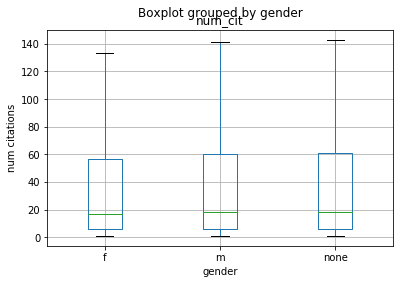

In [27]:
#print(authorCitationsData.head(n=2))
print(authorCitationsData['author'].nunique())
#print(authorCitationsData.shape[0])

print(authorCitationsData.head())
#print(authorCitationsData[authorCitationsData.author=="stefano rizzi"])


ax = authorCitationsData.boxplot(column='num_cit', by='gender', showfliers=False)
ax.set_ylabel("num citations")
ax.set_xlabel("gender")
plt.show()

### There are some differences between publication and citation data which is collected by DBLP and Aminer 
#### Data found for authors whose work were cited in the years which are lesser than their starting year of publishing. For our analysis these data are removed. Whereas author's work will be cited even after he/she ends their career

In [28]:
authorCitationsData.head()

,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender
40,1970.0,alfonso f. cardenas,2,1970.0,2011.0,48.0,41.0,m
81,1970.0,b. f. caviness,2,1970.0,1986.0,13.0,16.0,m
87,1970.0,ben wegbreit,9,1970.0,2011.0,30.0,41.0,none
218,1970.0,david pager,1,1970.0,2011.0,13.0,41.0,none
220,1970.0,david r. olsen,2,1970.0,2005.0,6.0,35.0,none


In [29]:
print('authorCitationsData before filtering', authorCitationsData.shape[0])
temp =  authorCitationsData[authorCitationsData['year'] < authorCitationsData['start_year']]
print(temp.shape[0],' rows were present')

authorCitationsData = authorCitationsData[authorCitationsData['year'] >= authorCitationsData['start_year']]
authorCitationsData = authorCitationsData.reset_index(drop = True)

print('authorCitationsData after filtering', authorCitationsData.shape[0])
authorCitationsData.head()

authorCitationsData before filtering 1788497
2423  rows were present
authorCitationsData after filtering 1786074
     year                author  num_cit  start_year  end_year  total_num_pub  \
0  1970.0   alfonso f. cardenas        2      1970.0    2011.0           48.0   
1  1970.0        b. f. caviness        2      1970.0    1986.0           13.0   
2  1970.0          ben wegbreit        9      1970.0    2011.0           30.0   
3  1970.0           david pager        1      1970.0    2011.0           13.0   
4  1970.0        david r. olsen        2      1970.0    2005.0            6.0   
5  1970.0  dimitris g. maritsas        8      1970.0    2000.0           12.0   
6  1970.0       donald r. slutz        1      1970.0    2002.0           12.0   
7  1970.0   edward l. robertson        2      1970.0    2011.0           48.0   
8  1970.0       forbes d. lewis        2      1970.0    1993.0            9.0   
9  1970.0     fred g. gustavson        1      1970.0    2013.0           85.0

### Test Data

In [ ]:
groupByYearData = authorCitationsData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 1, 'num_cit')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

# Cohort Analysis on all authors for 15 years

#### Select Cohorts based on Start Years

In [31]:
years = authorCitationsData['year'].unique()
years = sorted(years)
print(years)


cohort_start_years = [y for y in years if y < (END_YEAR - CAREER_LENGTH)]
#cohort_start_years = [1974, 1984, 1994]

[1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0]


### Cohort Analysis (Num Cit)

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/

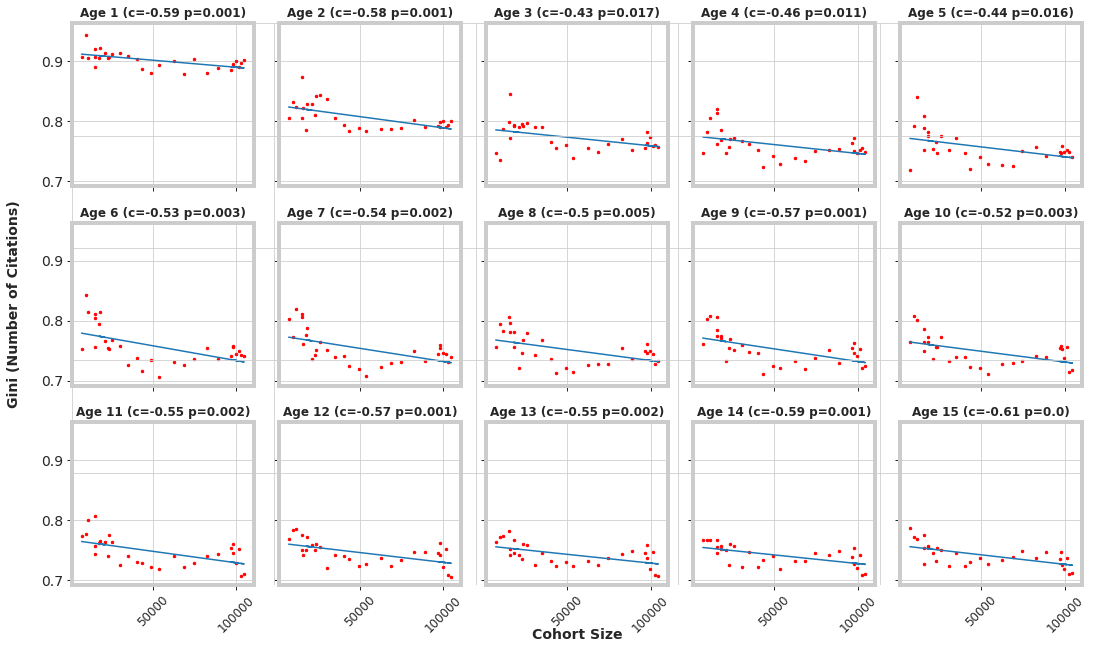

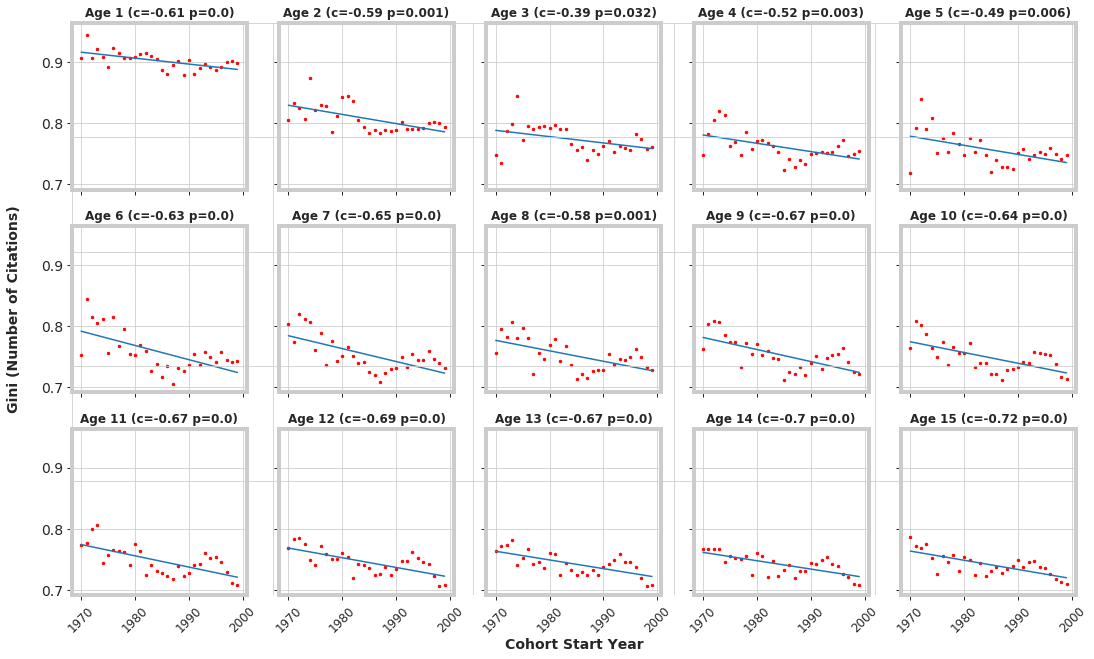

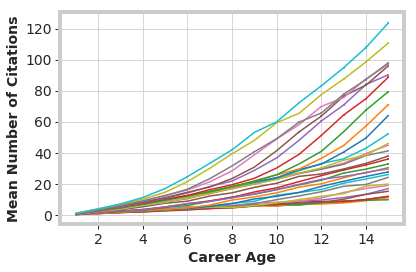

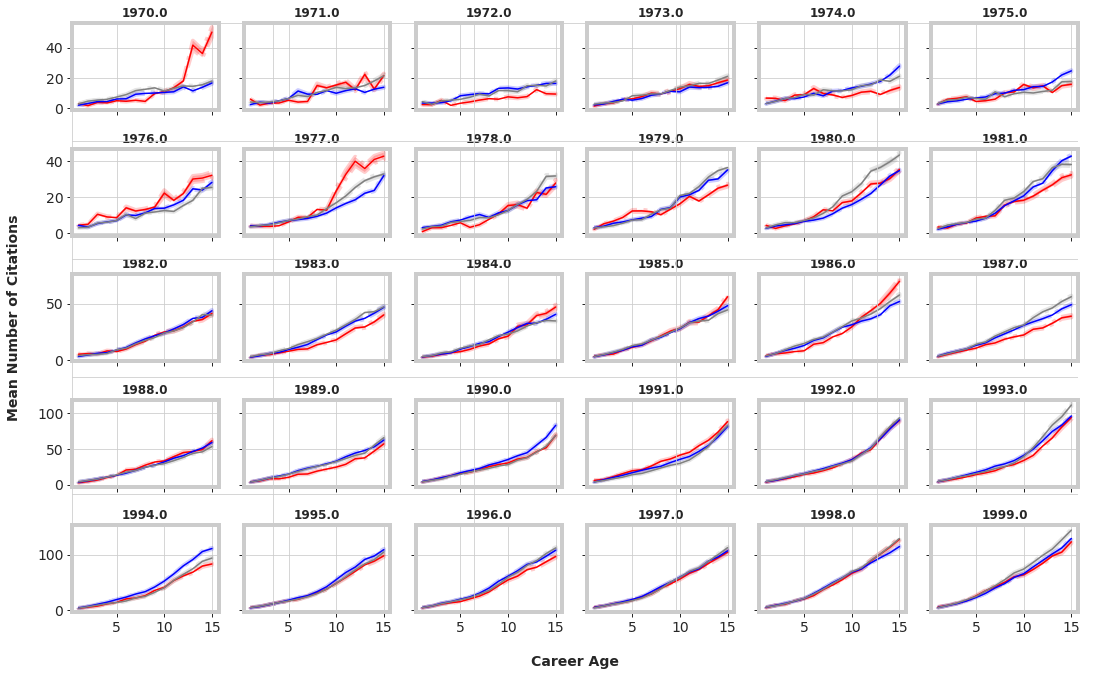

In [33]:
#print(plt.style.available)
from importlib import reload

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', cohort_start_years, CAREER_LENGTH, 'Citations Count')

plot.run_cohort_analysis(authorCitationsData, cohort_start_years, CAREER_LENGTH, "num_cit", "Number of Citations")  


### Cohort Analysis (Cum Num Cit)

In [ ]:
plot.run_cohort_analysis(authorCitationsData, cohort_start_years, 
                         CAREER_LENGTH, "cum_num_cit", "Cumulative Number of Citations")  

### Cumulative Distributions for Selected Cohorts and Career Ages

how do these distributions differ?

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


KeyError: "['cum_num_cit'] not in index"

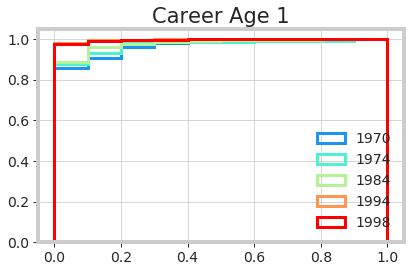

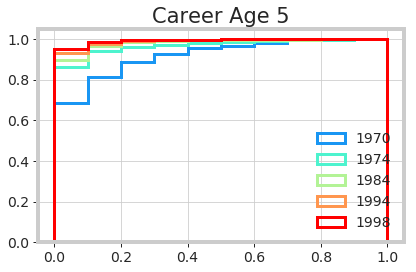

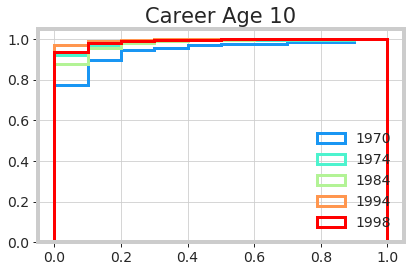

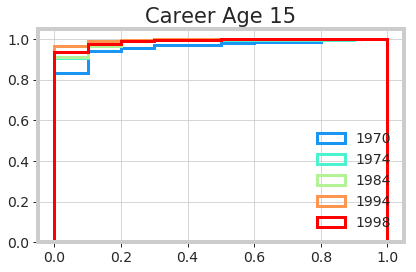

In [38]:
cohort_start_years = [1970, 1974, 1984, 1994, 1998]

cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'num_cit')
plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_cit', 'Number of Citations')

cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'cum_num_cit')
plot.plot_cumulative_dist(cohort_careerage_df, 1, 'cum_num_cit', 'Cumulative Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 5, 'cum_num_cit', 'Cumulative Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 10, 'cum_num_cit', 'Cumulative Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 15, 'cum_num_cit', 'Cumulative Number of Citations')

### Why is there a sudden increase in mean citation count for cohort started in 1985?

In [39]:
_1985Authors = authorCitationsData[authorCitationsData['start_year'] == 1985] 
_1985Authors.shape

(43449, 8)

In [40]:
_1985Authors.columns

Index(['year', 'author', 'num_cit', 'start_year', 'end_year', 'total_num_pub',
       'career_length', 'gender'],
      dtype='object')

In [42]:
# _1985Authors.sort_values(by=['num_cit'], axis = 0, ascending=False,inplace=False)

In [43]:
_1995_year_1985Authors = _1985Authors[_1985Authors['year'] >= 1995]
_1995_2000_year_1985Authors = _1985Authors[_1985Authors['year'] <= 2000]
print(_1995_2000_year_1985Authors.shape)
_1995_2000_year_1985Authors.head(10)

(17004, 8)


,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender
25667,1985.0,a. j. j. dick,3,1985.0,2005.0,2.0,20.0,m
25704,1985.0,abderrahman bouhamidi,1,1985.0,2016.0,18.0,31.0,m
25718,1985.0,adnan h. yahya,2,1985.0,2014.0,15.0,29.0,m
25742,1985.0,akio shinagawa,4,1985.0,2011.0,2.0,26.0,m
25746,1985.0,akira matsumoto,8,1985.0,2015.0,15.0,30.0,m
25772,1985.0,alan f. newell,6,1985.0,2012.0,52.0,27.0,none
25812,1985.0,alberto cavicchioli,2,1985.0,2013.0,7.0,28.0,m
25838,1985.0,alexander l. wolf,3,1985.0,2016.0,109.0,31.0,none
25844,1985.0,alexander skavantzos,1,1985.0,2012.0,16.0,27.0,m
25874,1985.0,allen a. mcintosh,2,1985.0,2007.0,4.0,22.0,none


In [44]:
temp_group = _1995_2000_year_1985Authors.groupby(by=['year','author'])['num_cit']
temp = temp_group.sum().reset_index().sort_values(by='num_cit',ascending=False)
temp.head()

#print(temp1['id2'].unique())

,year,author,num_cit
10455,1995.0,robert k. brayton,980
11634,1996.0,robert k. brayton,929
15411,1999.0,robert k. brayton,810
9254,1994.0,robert k. brayton,801
14131,1998.0,robert k. brayton,783


In [45]:
donatella = _1985Authors[_1985Authors['author'] == 'donatella sciuto']
donatella

,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


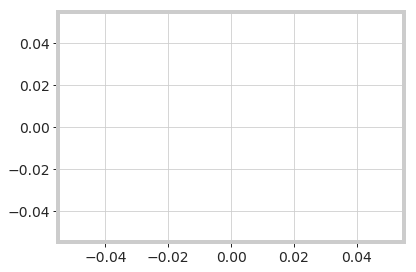

In [46]:
plt.scatter(x=donatella['year'],y=donatella['num_cit'])

In [48]:
# authorCitationsData[authorCitationsData['author'] == 'donatella sciuto']

## Research Question 1
Is inequality increasing with increasing competition (i.e. do larger cohorts jhave higher inequality?)?
Analyse the correlation plots. Plot signigicance of correlation between cohort size and gini for each career age.

## Research Question 2
How is the position of men and women changing as inequality increases?
We see that the mean cumulative productivity and success are increasing for both groups is a similar way. Some cohorts are different but for most of them no big gender differences are visible.



### Regression Analysis of mean productivity on Inequality for all authors for 15 years
- There is no relation at all - Reg. coefficient is 0

In [ ]:
#just for debugging
reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#print(data.head())

In [ ]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 30 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)